In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("..").resolve()))

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score
from Implementations.plot_style import set_latex_style, fig_ax, save_pdf

In [2]:
# Trains a simple GRU/LSTM on valuation-sequence NPZ:
#   X_seq:    (N, T, F_seq)
#   X_static: (N, F_static)
#   y:        (N,)  (log target)
#   target_date: (N,) datetime64[ns]

In [3]:
# -----------------------
# 1) Load dataset
# -----------------------
npz_path = "../Data_Processed/valuation_seq_rnn_dataset.npz"

d = np.load(npz_path, allow_pickle=True)
X_seq = d["X_seq"].astype(np.float32)
X_static = d["X_static"].astype(np.float32)
y = d["y"].astype(np.float32)
target_date = pd.to_datetime(d["target_date"])

print("Loaded:")
print("  X_seq:", X_seq.shape)
print("  X_static:", X_static.shape)
print("  y:", y.shape)
print("  target_date:", target_date.min(), "->", target_date.max())


Loaded:
  X_seq: (337430, 5, 11)
  X_static: (337430, 10)
  y: (337430,)
  target_date: 2005-04-03 00:00:00 -> 2025-03-31 00:00:00


In [4]:
# -----------------------
# 2) Time-based split 
# -----------------------
train_end = pd.Timestamp("2021-12-31")
val_end = pd.Timestamp("2023-12-31")

train_idx = np.where(target_date <= train_end)[0]
val_idx = np.where((target_date > train_end) & (target_date <= val_end))[0]
test_idx = np.where(target_date > val_end)[0]

print("Split sizes:", len(train_idx), len(val_idx), len(test_idx))


Split sizes: 251794 67018 18618


In [5]:
# -----------------------
# 3) Standardize features using TRAIN ONLY
#    (very important for neural nets)
# -----------------------
def fit_standardizer_seq(X_seq_train):
    # X_seq_train: (N, T, F)
    # compute mean/std over N and T for each feature
    mu = X_seq_train.reshape(-1, X_seq_train.shape[-1]).mean(axis=0)
    sigma = X_seq_train.reshape(-1, X_seq_train.shape[-1]).std(axis=0)
    sigma = np.where(sigma < 1e-8, 1.0, sigma)
    return mu.astype(np.float32), sigma.astype(np.float32)

def apply_standardizer_seq(X_seq, mu, sigma):
    return (X_seq - mu[None, None, :]) / sigma[None, None, :]

def fit_standardizer_tab(X_tab_train):
    mu = X_tab_train.mean(axis=0)
    sigma = X_tab_train.std(axis=0)
    sigma = np.where(sigma < 1e-8, 1.0, sigma)
    return mu.astype(np.float32), sigma.astype(np.float32)

def apply_standardizer_tab(X_tab, mu, sigma):
    return (X_tab - mu[None, :]) / sigma[None, :]

seq_mu, seq_sigma = fit_standardizer_seq(X_seq[train_idx])
static_mu, static_sigma = fit_standardizer_tab(X_static[train_idx])

X_seq = apply_standardizer_seq(X_seq, seq_mu, seq_sigma)
X_static = apply_standardizer_tab(X_static, static_mu, static_sigma)

print("Standardization done (train-only).")



Standardization done (train-only).


In [6]:
# -----------------------
# 4) Torch Dataset
# -----------------------
class ValSeqDataset(Dataset):
    def __init__(self, X_seq, X_static, y):
        self.X_seq = torch.tensor(X_seq, dtype=torch.float32)
        self.X_static = torch.tensor(X_static, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        return self.X_seq[idx], self.X_static[idx], self.y[idx]

train_ds = ValSeqDataset(X_seq[train_idx], X_static[train_idx], y[train_idx])
val_ds = ValSeqDataset(X_seq[val_idx], X_static[val_idx], y[val_idx])
test_ds = ValSeqDataset(X_seq[test_idx], X_static[test_idx], y[test_idx])

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)



In [7]:
# -----------------------
# 5) Model Architectures GRU and LSTM
# -----------------------
class GRURegressor(nn.Module):
    def __init__(self, seq_dim, static_dim, hidden_dim=64):
        super().__init__()
        self.rnn = nn.GRU(seq_dim, hidden_dim, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(hidden_dim + static_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x_seq, x_static):
        _, h = self.rnn(x_seq)      # h: (1, B, H)
        h = h.squeeze(0)            # (B, H)
        x = torch.cat([h, x_static], dim=1)
        return self.head(x)

class LSTMRegressor(nn.Module):
    def __init__(self, seq_dim, static_dim, hidden_dim=64):
        super().__init__()
        self.rnn = nn.LSTM(seq_dim, hidden_dim, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(hidden_dim + static_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x_seq, x_static):
        _, (h, c) = self.rnn(x_seq)  # h: (1, B, H)
        h = h.squeeze(0)
        x = torch.cat([h, x_static], dim=1)
        return self.head(x)


In [8]:
# -----------------------
# 6) Train / eval loops
# -----------------------
def run_epoch(model, loader, optimizer=None,device="cuda" if torch.cuda.is_available() else "cpu",loss_fn = nn.MSELoss()):
    train = optimizer is not None
    model.train(train)

    total = 0.0
    n = 0

    for x_seq_b, x_static_b, y_b in loader:
        x_seq_b = x_seq_b.to(device)
        x_static_b = x_static_b.to(device)
        y_b = y_b.to(device)

        pred = model(x_seq_b, x_static_b)
        loss = loss_fn(pred, y_b)

        if train:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        bs = y_b.size(0)
        total += loss.item() * bs
        n += bs

    return total / max(n, 1)



In [9]:
# -----------------------
# 7) Extra eval metrics
# -----------------------

def eval_r2(model, loader, device):
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for x_seq, x_static, y in loader:
            x_seq = x_seq.to(device)
            x_static = x_static.to(device)
            y = y.to(device)

            pred = model(x_seq, x_static)

            y_true.append(y.cpu().numpy().ravel())
            y_pred.append(pred.cpu().numpy().ravel())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    r2 = r2_score(y_true, y_pred)

    return r2

def eval_metrics(model, loader,device):
    model.eval()
    ys = []
    preds = []
    with torch.no_grad():
        for x_seq_b, x_static_b, y_b in loader:
            x_seq_b = x_seq_b.to(device)
            x_static_b = x_static_b.to(device)
            y_b = y_b.to(device)

            pred = model(x_seq_b, x_static_b)
            ys.append(y_b.cpu().numpy().ravel())
            preds.append(pred.cpu().numpy().ravel())

    y_true = np.concatenate(ys)
    y_pred = np.concatenate(preds)

    mse = np.mean((y_true - y_pred) ** 2)
    r2 = r2_score(y_true, y_pred)
    return mse, r2


### GNU RNN network

In [10]:

seq_dim = X_seq.shape[2]
static_dim = X_static.shape[1]


device = "cuda" if torch.cuda.is_available() else "cpu"

model = (GRURegressor(seq_dim, static_dim, 64)).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

best_val = float("inf")
best_state = None

gru_train_mse = []
gru_val_mse = []
gru_train_r2 = []
gru_val_r2 = []

EPOCHS = 15
for epoch in range(1, EPOCHS + 1):
    train_mse = run_epoch(model, train_loader, optimizer,device=device,loss_fn=loss_fn)
    val_mse = run_epoch(model, val_loader, optimizer=None)

    gru_train_mse.append(train_mse)
    gru_val_mse.append(val_mse)
    gru_train_r2.append(eval_r2(model,train_loader,device=device))
    gru_val_r2.append(eval_r2(model,val_loader,device=device))

    print(f"Epoch {epoch:02d} | train MSE: {train_mse:.4f} | val MSE: {val_mse:.4f}")

    if val_mse < best_val:
        best_val = val_mse
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

print("Best val MSE:", best_val)

if best_state is not None:
    model.load_state_dict(best_state)

test_mse = run_epoch(model, test_loader, optimizer=None)
print("Test MSE (log scale):", test_mse)

# Optional: convert to "multiplicative error factor" approx
rmse_log = float(np.sqrt(test_mse))
print("Test RMSE (log units):", rmse_log)
print("Approx multiplicative factor exp(RMSE):", float(np.exp(rmse_log)))


Epoch 01 | train MSE: 7.4963 | val MSE: 0.0797
Epoch 02 | train MSE: 0.0901 | val MSE: 0.0827
Epoch 03 | train MSE: 0.0888 | val MSE: 0.0785
Epoch 04 | train MSE: 0.0874 | val MSE: 0.0878
Epoch 05 | train MSE: 0.0876 | val MSE: 0.0790
Epoch 06 | train MSE: 0.0869 | val MSE: 0.0761
Epoch 07 | train MSE: 0.0866 | val MSE: 0.0801
Epoch 08 | train MSE: 0.0866 | val MSE: 0.1012
Epoch 09 | train MSE: 0.0864 | val MSE: 0.0767
Epoch 10 | train MSE: 0.0855 | val MSE: 0.0765
Epoch 11 | train MSE: 0.0856 | val MSE: 0.0773
Epoch 12 | train MSE: 0.0852 | val MSE: 0.0790
Epoch 13 | train MSE: 0.0851 | val MSE: 0.0836
Epoch 14 | train MSE: 0.0845 | val MSE: 0.0759
Epoch 15 | train MSE: 0.0852 | val MSE: 0.0766
Best val MSE: 0.07588677043273942
Test MSE (log scale): 0.061909154920294224
Test RMSE (log units): 0.24881550377798853
Approx multiplicative factor exp(RMSE): 1.2825053938410877


In [11]:
print(model)

GRURegressor(
  (rnn): GRU(11, 64, batch_first=True)
  (head): Sequential(
    (0): Linear(in_features=74, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [12]:
train_mse, train_r2 = eval_metrics(model, train_loader,device=device)
val_mse, val_r2 = eval_metrics(model, val_loader,device=device)
test_mse, test_r2 = eval_metrics(model, test_loader,device=device)

print(f"Train  | MSE: {train_mse:.4f} | R2: {train_r2:.4f}")
print(f"Val    | MSE: {val_mse:.4f} | R2: {val_r2:.4f}")
print(f"Test   | MSE: {test_mse:.4f} | R2: {test_r2:.4f}")


Train  | MSE: 0.0830 | R2: 0.9597
Val    | MSE: 0.0759 | R2: 0.9694
Test   | MSE: 0.0619 | R2: 0.9753


### LTSM (Long short term memory) model

In [13]:

seq_dim = X_seq.shape[2]
static_dim = X_static.shape[1]


device = "cuda" if torch.cuda.is_available() else "cpu"

model = (LSTMRegressor(seq_dim, static_dim, 64)).to(device)        


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

best_val = float("inf")
best_state = None

lstm_train_mse = []
lstm_val_mse = []
lstm_train_r2 = []
lstm_val_r2 = []

EPOCHS = 15
for epoch in range(1, EPOCHS + 1):
    train_mse = run_epoch(model, train_loader, optimizer,device=device,loss_fn=loss_fn)
    val_mse = run_epoch(model, val_loader, optimizer=None)

    lstm_train_mse.append(train_mse)
    lstm_val_mse.append(val_mse)
    lstm_train_r2.append(eval_r2(model,train_loader,device=device))
    lstm_val_r2.append(eval_r2(model,val_loader,device=device))

    print(f"Epoch {epoch:02d} | train MSE: {train_mse:.4f} | val MSE: {val_mse:.4f}")

    if val_mse < best_val:
        best_val = val_mse
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

print("Best val MSE:", best_val)

if best_state is not None:
    model.load_state_dict(best_state)

test_mse = run_epoch(model, test_loader, optimizer=None)
print("Test MSE (log scale):", test_mse)

# Optional: convert to "multiplicative error factor" approx
rmse_log = float(np.sqrt(test_mse))
print("Test RMSE (log units):", rmse_log)
print("Approx multiplicative factor exp(RMSE):", float(np.exp(rmse_log)))


Epoch 01 | train MSE: 7.4020 | val MSE: 0.0839
Epoch 02 | train MSE: 0.0887 | val MSE: 0.0800
Epoch 03 | train MSE: 0.0897 | val MSE: 0.0806
Epoch 04 | train MSE: 0.0882 | val MSE: 0.0851
Epoch 05 | train MSE: 0.0878 | val MSE: 0.0845
Epoch 06 | train MSE: 0.0870 | val MSE: 0.0866
Epoch 07 | train MSE: 0.0865 | val MSE: 0.0788
Epoch 08 | train MSE: 0.0865 | val MSE: 0.0926
Epoch 09 | train MSE: 0.0870 | val MSE: 0.0778
Epoch 10 | train MSE: 0.0854 | val MSE: 0.0762
Epoch 11 | train MSE: 0.0864 | val MSE: 0.0768
Epoch 12 | train MSE: 0.0862 | val MSE: 0.0770
Epoch 13 | train MSE: 0.0856 | val MSE: 0.0773
Epoch 14 | train MSE: 0.0856 | val MSE: 0.0755
Epoch 15 | train MSE: 0.0851 | val MSE: 0.0764
Best val MSE: 0.07548289712983267
Test MSE (log scale): 0.06010228175522241
Test RMSE (log units): 0.2451576671352997
Approx multiplicative factor exp(RMSE): 1.2778227679783187


In [14]:
print(model)

LSTMRegressor(
  (rnn): LSTM(11, 64, batch_first=True)
  (head): Sequential(
    (0): Linear(in_features=74, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [15]:
train_mse, train_r2 = eval_metrics(model, train_loader,device=device)
val_mse, val_r2 = eval_metrics(model, val_loader,device=device)
test_mse, test_r2 = eval_metrics(model, test_loader,device=device)

print(f"Train  | MSE: {train_mse:.4f} | R2: {train_r2:.4f}")
print(f"Val    | MSE: {val_mse:.4f} | R2: {val_r2:.4f}")
print(f"Test   | MSE: {test_mse:.4f} | R2: {test_r2:.4f}")



Train  | MSE: 0.0822 | R2: 0.9601
Val    | MSE: 0.0755 | R2: 0.9695
Test   | MSE: 0.0601 | R2: 0.9760


### Plotting

In [16]:
set_latex_style(usetex=True)


Saved: ../Plots/fig_gru_lstm_mse_vs_epoch.pdf


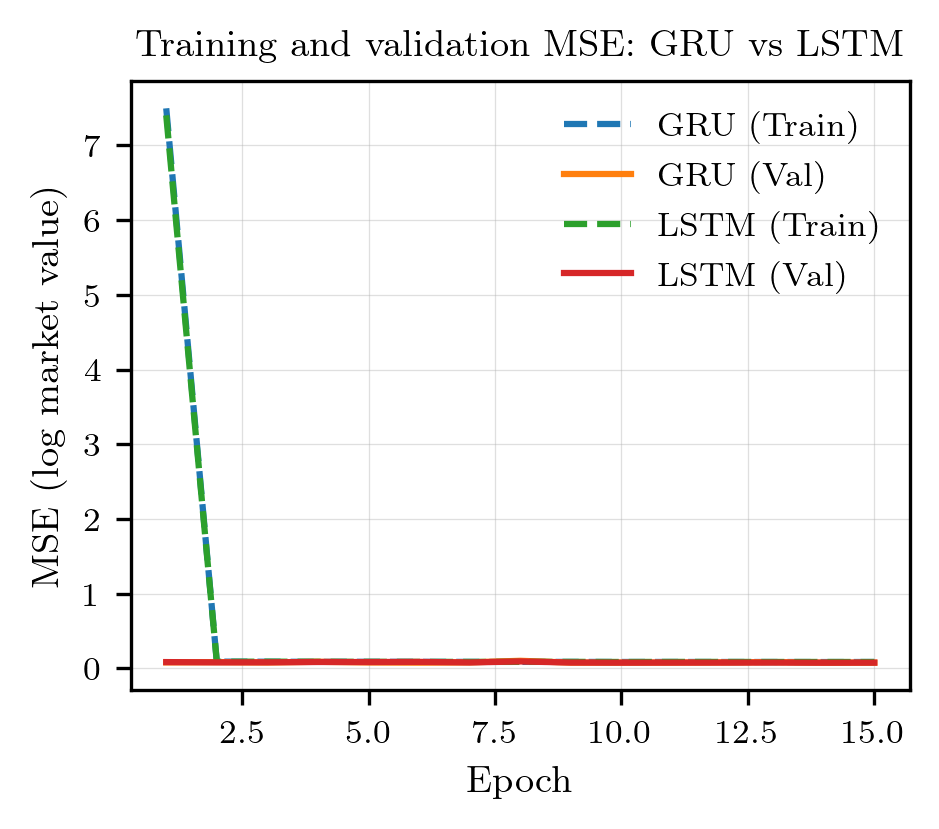

In [17]:
epochs = np.arange(1, len(gru_train_mse) + 1)

fig, ax = fig_ax("onecol", height_scale=1.2)

ax.plot(epochs, gru_train_mse, label="GRU (Train)", linestyle="--")
ax.plot(epochs, gru_val_mse,   label="GRU (Val)")

ax.plot(epochs, lstm_train_mse, label="LSTM (Train)", linestyle="--")
ax.plot(epochs, lstm_val_mse,   label="LSTM (Val)")

ax.set_xlabel("Epoch")
ax.set_ylabel(r"MSE (log market value)")
ax.set_title(r"Training and validation MSE: GRU vs LSTM")

ax.grid(True, linewidth=0.3, alpha=0.4)
ax.legend(frameon=False)

save_pdf(fig, "fig_gru_lstm_mse_vs_epoch.pdf", folder="../Plots")
print("Saved: ../Plots/fig_gru_lstm_mse_vs_epoch.pdf")


Saved: ../Plots/fig_gru_lstm_r2_vs_epoch.pdf


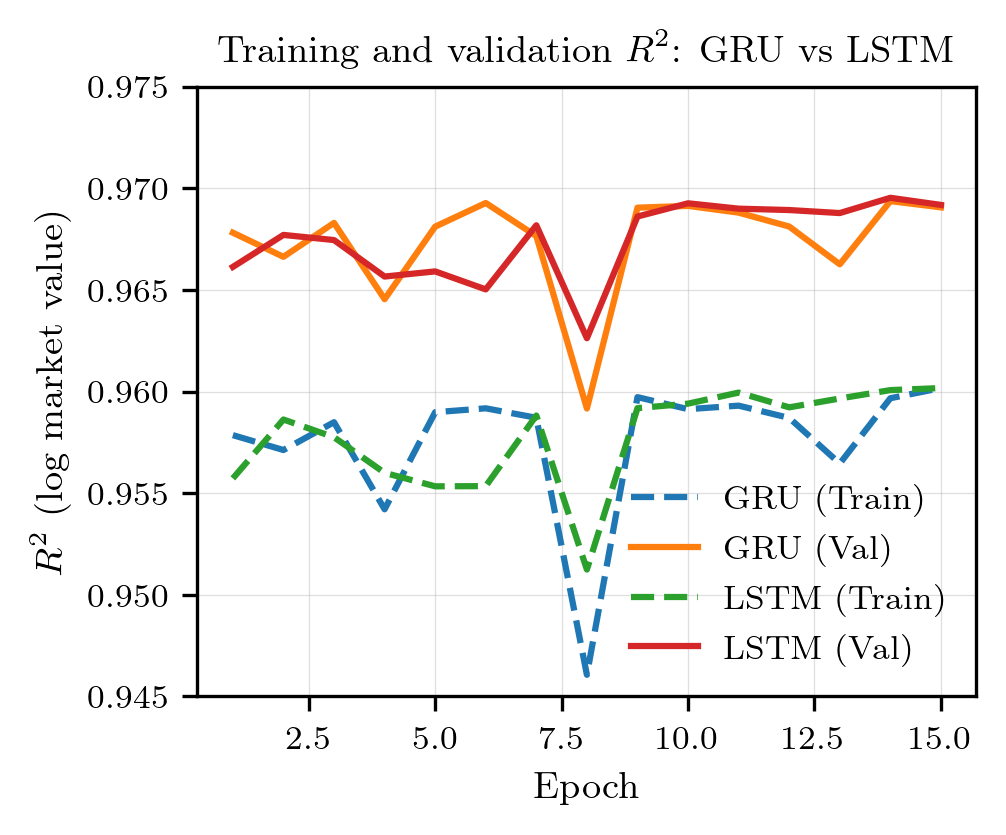

In [18]:
epochs = np.arange(1, len(gru_train_r2) + 1)

fig, ax = fig_ax("onecol", height_scale=1.2)

ax.plot(epochs, gru_train_r2, label="GRU (Train)", linestyle="--")
ax.plot(epochs, gru_val_r2,   label="GRU (Val)")

ax.plot(epochs, lstm_train_r2, label="LSTM (Train)", linestyle="--")
ax.plot(epochs, lstm_val_r2,   label="LSTM (Val)")

ax.set_xlabel("Epoch")
ax.set_ylabel(r"$R^2$ (log market value)")
ax.set_title(r"Training and validation $R^2$: GRU vs LSTM")

ax.grid(True, linewidth=0.3, alpha=0.4)
ax.legend(frameon=False)

ax.set_ylim(0.945, 0.975)  # optional but often nice for R^2

save_pdf(fig, "fig_gru_lstm_r2_vs_epoch.pdf", folder="../Plots")
print("Saved: ../Plots/fig_gru_lstm_r2_vs_epoch.pdf")


### Finding specific player values

In [19]:
player_id = d["player_id"]

In [20]:
def predict_player_value(player_id_query, target_date_query, return_log=False):
    """
    Predict market value for an existing (player_id, target_date) using the trained RNN.
    Assumes all data arrays and standardization parameters are available as globals.
    """

    # Ensure date format
    t_query = pd.Timestamp(target_date_query)

    # Find matching row
    mask = (player_id == int(player_id_query)) & (target_date == t_query)
    idxs = np.where(mask)[0]

    if len(idxs) == 0:
        raise ValueError("No matching (player_id, target_date) found in dataset.")

    idx = int(idxs[0])

    # Extract sample
    x_seq = X_seq[idx:idx+1]
    x_static = X_static[idx:idx+1]

    # Standardize (same as training)
    x_seq = (x_seq - seq_mu[None, None, :]) / seq_sigma[None, None, :]
    x_static = (x_static - static_mu[None, :]) / static_sigma[None, :]

    x_seq_t = torch.tensor(x_seq, dtype=torch.float32).to(device)
    x_static_t = torch.tensor(x_static, dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        pred_log = float(model(x_seq_t, x_static_t).cpu().numpy().ravel()[0])

    true_log = float(y[idx])

    if return_log:
        return pred_log, true_log

    pred_eur = float(np.expm1(pred_log))
    true_eur = float(np.expm1(true_log))

    return pred_eur, true_eur


In [21]:
predict_player_value(418560,"2023-12-19")

(7676.342283479465, 179999875.11082527)

### Checking for teams

In [22]:
player_ids = [
    257814, 370789, 39728, 388198, 485585, 106987, 119296, 401173,
    187492, 496094, 75489,
    108390, 138927, 86202, 58884, 291417, 640428, 369081, 31909,
    581678, 412363, 371998
]

full_names = [
    "Gregor Kobel",
    "Julian Ryerson",
    "Mats Hummels",
    "Nico Schlotterbeck",
    "Ian Maatsen",
    "Marcel Sabitzer",
    "Emre Can",
    "Jadon Sancho",
    "Julian Brandt",
    "Karim Adeyemi",
    "Niclas Füllkrug",
    "Thibaut Courtois",
    "Daniel Carvajal",
    "Antonio Rüdiger",
    "Nacho Fernández",
    "Ferland Mendy",
    "Eduardo Camavinga",
    "Federico Valverde",
    "Toni Kroos",
    "Jude Bellingham",
    "Rodrygo Rodrygo",
    "Vinicius Junior"
]

clubs = [
    "Borussia Dortmund",
    "Borussia Dortmund",
    "Borussia Dortmund",
    "Borussia Dortmund",
    "Borussia Dortmund",
    "Borussia Dortmund",
    "Borussia Dortmund",
    "Borussia Dortmund",
    "Borussia Dortmund",
    "Borussia Dortmund",
    "Borussia Dortmund",
    "Real Madrid Club de Fútbol",
    "Real Madrid Club de Fútbol",
    "Real Madrid Club de Fútbol",
    "Real Madrid Club de Fútbol",
    "Real Madrid Club de Fútbol",
    "Real Madrid Club de Fútbol",
    "Real Madrid Club de Fútbol",
    "Real Madrid Club de Fútbol",
    "Real Madrid Club de Fútbol",
    "Real Madrid Club de Fútbol",
    "Real Madrid Club de Fútbol"
]


In [23]:


for i in range(len(player_ids)):
    print(f"Player: {full_names[i]}, club: {clubs[i]}")
    if clubs[i] ==  "Borussia Dortmund":
        pred_val, true_val = predict_player_value(player_ids[i],"2024-05-29")
    else:
        pred_val, true_val = predict_player_value(player_ids[i],"2024-06-07")
    print(f"Predicted value {pred_val}, true value {true_val:0f}")
    print(f"\n")

Player: Gregor Kobel, club: Borussia Dortmund
Predicted value 2110.196702729481, true value 40000027.178991


Player: Julian Ryerson, club: Borussia Dortmund
Predicted value 1634.0526341655464, true value 20000003.514655


Player: Mats Hummels, club: Borussia Dortmund
Predicted value 1133.3752279721841, true value 5000000.109617


Player: Nico Schlotterbeck, club: Borussia Dortmund
Predicted value 2017.6739482875298, true value 40000027.178991


Player: Ian Maatsen, club: Borussia Dortmund
Predicted value 1632.3569872362598, true value 40000027.178991


Player: Marcel Sabitzer, club: Borussia Dortmund
Predicted value 5959.031465124178, true value 20000003.514655


Player: Emre Can, club: Borussia Dortmund
Predicted value 1510.9645109027758, true value 9999996.469909


Player: Jadon Sancho, club: Borussia Dortmund
Predicted value 1807.4856096548583, true value 29999977.699642


Player: Julian Brandt, club: Borussia Dortmund
Predicted value 3647.9863814035693, true value 40000027.178991


### Checking dataset construction

We have a very high R2 score so i want to double check to see if we have any form of data leakage.

In [24]:
# =========================
# Leak-check + “does this sample make sense?” inspector
# =========================
# Run this in the same project where you have:
#   Data/player_valuations.csv
#   Data/game_events.csv
#   Data_Processed/valuation_seq_rnn_dataset.npz
#
# It prints a few random samples in HUMAN terms and runs hard leakage checks.


# -------------------------
# Paths (edit if needed)
# -------------------------
PROJECT_ROOT = Path.cwd().parent  # if you're in Code/Implementations
DATA_DIR = PROJECT_ROOT / "Data"
PROC_DIR = PROJECT_ROOT / "Data_Processed"

NPZ_PATH = PROC_DIR / "valuation_seq_rnn_dataset.npz"
VALUATIONS_CSV = DATA_DIR / "player_valuations.csv"
EVENTS_CSV = DATA_DIR / "game_events.csv"

# -------------------------
# Load NPZ (RAW, unstandardized)
# -------------------------
d = np.load(NPZ_PATH, allow_pickle=True)
X_seq = d["X_seq"].astype(np.float32)          # (N, T, 11)
X_static = d["X_static"].astype(np.float32)    # (N, 10)
y = d["y"].astype(np.float32)                  # (N,)
player_id = d["player_id"].astype(np.int64) if "player_id" in d.files else None
target_date = pd.to_datetime(d["target_date"]) if "target_date" in d.files else None

print("NPZ keys:", d.files)
print("X_seq:", X_seq.shape, "X_static:", X_static.shape, "y:", y.shape)
print("target_date range:", target_date.min(), "->", target_date.max())

# Feature names used in your builder script
SEQ_FEATURE_NAMES = [
    "y_prev_log", "H_days", "num_games",
    "goals_sum", "assists_sum", "yellow_sum", "red_sum", "sub_in_sum", "sub_out_sum",
    "age_prev", "big5_prev"
]

# -------------------------
# Load raw CSVs (for verification)
# -------------------------
valuations = pd.read_csv(VALUATIONS_CSV, low_memory=False)
valuations["player_id"] = pd.to_numeric(valuations["player_id"], errors="coerce")
valuations = valuations.dropna(subset=["player_id"]).copy()
valuations["player_id"] = valuations["player_id"].astype(np.int64)
valuations["date"] = pd.to_datetime(valuations["date"], errors="coerce")
valuations["market_value_in_eur"] = pd.to_numeric(valuations["market_value_in_eur"], errors="coerce")
valuations = valuations.dropna(subset=["date", "market_value_in_eur"]).copy()
valuations["y_log"] = np.log1p(valuations["market_value_in_eur"].astype(np.float32))
valuations = valuations.sort_values(["player_id", "date"]).reset_index(drop=True)

events = pd.read_csv(EVENTS_CSV, low_memory=False)
events["date"] = pd.to_datetime(events["date"], errors="coerce")
events = events.dropna(subset=["date"]).copy()
events["game_id"] = pd.to_numeric(events.get("game_id"), errors="coerce")
events = events.dropna(subset=["game_id"]).copy()
events["game_id"] = events["game_id"].astype(np.int64)

# game_dates needed for interval filtering
game_dates = events.groupby("game_id")["date"].min()

# Helper to count events in an interval (start, end]
def interval_event_sums(pid, start_date, end_date):
    # Filter events by date first (fast-ish), then by player columns
    # NOTE: this assumes "type"/"description" follow the same meaning as in your builder.
    e = events[(events["date"] > start_date) & (events["date"] <= end_date)].copy()
    if len(e) == 0:
        return 0, np.zeros(6, dtype=np.float32)

    desc = e.get("description", pd.Series([""] * len(e))).fillna("")
    etype = e.get("type", pd.Series([""] * len(e)))

    is_goal = etype == "Goals"
    is_yellow = (etype == "Cards") & desc.str.contains("Yellow card", case=False, na=False)
    is_red = (etype == "Cards") & desc.str.contains("Red card", case=False, na=False)
    is_sub = etype == "Substitutions"

    # Make sure columns exist
    def count(col, mask):
        if col not in e.columns:
            return 0
        tmp = e.loc[mask, col]
        tmp = pd.to_numeric(tmp, errors="coerce").dropna().astype(np.int64)
        return int((tmp == pid).sum())

    goals = count("player_id", is_goal)
    assists = count("player_assist_id", is_goal)
    yellow = count("player_id", is_yellow)
    red = count("player_id", is_red)
    sub_in = count("player_in_id", is_sub)
    sub_out = count("player_id", is_sub)

    # num_games: count distinct game_ids where player appears in any relevant column
    cols = [c for c in ["player_id", "player_assist_id", "player_in_id"] if c in e.columns]
    mask_any = False
    for c in cols:
        tmp = pd.to_numeric(e[c], errors="coerce")
        if isinstance(mask_any, bool) and mask_any is False:
            mask_any = (tmp == pid)
        else:
            mask_any = mask_any | (tmp == pid)

    num_games = int(e.loc[mask_any, "game_id"].nunique()) if not isinstance(mask_any, bool) else 0

    return num_games, np.array([goals, assists, yellow, red, sub_in, sub_out], dtype=np.float32)

# -------------------------
# 1) Hard leakage checks on NPZ arrays
# -------------------------
print("\n=== HARD CHECKS (NPZ only) ===")

# Check finiteness
print("finite X_seq:", np.isfinite(X_seq).all())
print("finite X_static:", np.isfinite(X_static).all())
print("finite y:", np.isfinite(y).all())

# Check if target appears directly inside inputs (exact equality)
# (Not a proof, but a strong red flag if it happens a lot)
# Compare y to y_prev_log in last timestep:
y_prev_last = X_seq[:, -1, 0]
same_as_prev = np.mean(np.isclose(y_prev_last, y, atol=1e-7))
print("Fraction where y == last_step_y_prev_log exactly:", same_as_prev)

# If any timestep has y_prev_log == y exactly
same_any = np.mean(np.any(np.isclose(X_seq[:, :, 0], y[:, None], atol=1e-7), axis=1))
print("Fraction where y equals some timestep y_prev_log exactly:", same_any)

# Sanity ranges for key features
print("y range:", float(y.min()), float(y.max()))
print("H_days range:", float(X_seq[:, :, 1].min()), float(X_seq[:, :, 1].max()))
print("num_games range:", float(X_seq[:, :, 2].min()), float(X_seq[:, :, 2].max()))

# -------------------------
# 2) Verify time ordering against raw valuations (strong leakage test)
# -------------------------
print("\n=== TIME-ORDER CHECK (sampled) ===")

def inspect_sample(idx):
    pid = int(player_id[idx])
    t_tgt = target_date[idx]
    y_tgt = float(y[idx])

    # player's valuation history
    v = valuations[valuations["player_id"] == pid].sort_values("date").reset_index(drop=True)
    if len(v) == 0:
        print("No valuations found for pid", pid)
        return

    # find target row
    hit = np.where(v["date"].values == np.datetime64(t_tgt))[0]
    if len(hit) == 0:
        print("Target date not found in valuations for pid", pid, "target_date", t_tgt)
        return
    i_tgt = int(hit[0])

    # We built step k as (prev -> curr), with feature y_prev_log = y at prev date
    # For T=5, the last timestep should correspond to prev date = v[i_tgt-1].date
    if i_tgt == 0:
        print("Target is first valuation (should not happen in dataset) pid", pid)
        return

    prev_date = pd.Timestamp(v.loc[i_tgt - 1, "date"])
    y_prev_true = float(v.loc[i_tgt - 1, "y_log"])
    y_tgt_true = float(v.loc[i_tgt, "y_log"])

    seq = X_seq[idx]  # (T, 11)
    y_prev_last = float(seq[-1, 0])
    H_last = float(seq[-1, 1])
    num_games_last = float(seq[-1, 2])
    sums_last = seq[-1, 3:9].astype(float)

    print("\n--- SAMPLE idx", idx, "---")
    print("pid:", pid)
    print("target_date:", t_tgt, "target y (npz):", y_tgt)
    print("target y (from valuations.csv):", y_tgt_true)
    print("prev_date:", prev_date, "prev y_log (true):", y_prev_true)
    print("last timestep y_prev_log (from X_seq):", y_prev_last)
    print("last timestep H_days:", H_last, " (true days):", (t_tgt - prev_date).days)
    print("last timestep num_games:", num_games_last)

    # Interval verification for last step (prev_date, target_date]
    num_games_chk, sums_chk = interval_event_sums(pid, prev_date, t_tgt)
    print("interval check num_games:", num_games_chk)
    print("interval check sums [goals, assists, yellow, red, sub_in, sub_out]:", sums_chk.tolist())
    print("X_seq last-step sums:", sums_last.tolist())

    # Leakage red flags:
    # 1) last-step y_prev_log should match y at prev date (not current date)
    print("y_prev_log matches prev true?:", np.isclose(y_prev_last, y_prev_true, atol=1e-5))
    # 2) target y should not equal last y_prev_log in general (it can sometimes if value unchanged)
    print("target equals y_prev_log?:", np.isclose(y_tgt_true, y_prev_last, atol=1e-7))

    # Print full sequence timesteps (raw numbers)
    print("\nSequence timesteps (oldest -> newest):")
    df_seq = pd.DataFrame(seq, columns=SEQ_FEATURE_NAMES)
    print(df_seq)

# Inspect a few random samples
rng = np.random.default_rng(0)
for idx in rng.choice(len(y), size=3, replace=False):
    inspect_sample(int(idx))

NPZ keys: ['X_seq', 'X_static', 'y', 'player_id', 'target_date']
X_seq: (337430, 5, 11) X_static: (337430, 10) y: (337430,)
target_date range: 2005-04-03 00:00:00 -> 2025-03-31 00:00:00

=== HARD CHECKS (NPZ only) ===
finite X_seq: True
finite X_static: True
finite y: True
Fraction where y == last_step_y_prev_log exactly: 0.3060160625907596
Fraction where y equals some timestep y_prev_log exactly: 0.4169220282725306
y range: 9.210440635681152 19.113828659057617
H_days range: 1.0 3650.0
num_games range: 0.0 65.0

=== TIME-ORDER CHECK (sampled) ===

--- SAMPLE idx 214929 ---
pid: 199480
target_date: 2017-07-31 00:00:00 target y (npz): 12.611540794372559
target y (from valuations.csv): 12.611540794372559
prev_date: 2017-02-23 00:00:00 prev y_log (true): 12.07254695892334
last timestep y_prev_log (from X_seq): 12.07254695892334
last timestep H_days: 158.0  (true days): 158
last timestep num_games: 0.0
interval check num_games: 0
interval check sums [goals, assists, yellow, red, sub_in, sub

In [25]:
rng = np.random.default_rng(42)

for idx in rng.choice(len(y), size=5, replace=False):
    inspect_sample(int(idx))


--- SAMPLE idx 261153 ---
pid: 291110
target_date: 2020-08-04 00:00:00 target y (npz): 15.607270240783691
target y (from valuations.csv): 15.607270240783691
prev_date: 2020-04-08 00:00:00 prev y_log (true): 15.384126663208008
last timestep y_prev_log (from X_seq): 15.384126663208008
last timestep H_days: 118.0  (true days): 118
last timestep num_games: 8.0
interval check num_games: 8
interval check sums [goals, assists, yellow, red, sub_in, sub_out]: [1.0, 2.0, 3.0, 0.0, 1.0, 4.0]
X_seq last-step sums: [1.0, 2.0, 3.0, 0.0, 1.0, 4.0]
y_prev_log matches prev true?: True
target equals y_prev_log?: False

Sequence timesteps (oldest -> newest):
   y_prev_log  H_days  num_games  goals_sum  assists_sum  yellow_sum  red_sum  \
0   15.201805   168.0       17.0        3.0          1.0         5.0      0.0   
1   15.201805   123.0        8.0        3.0          1.0         3.0      0.0   
2   15.068274    91.0       10.0        8.0          1.0         6.0      0.0   
3   15.607270    96.0      